# Imports

In [ ]:
import os
import os.path
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt

#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pylab import rcParams

# Dataset Exploration

In [ ]:
breed_list = os.listdir("images/")
number_of_used_breed =40
from PIL import Image
breed_in_use = 1

# Creating training and testing dataset

In [ ]:
os.makedirs('Mydata',exist_ok= True)
os.makedirs('Mydata/Train',exist_ok= True)
os.makedirs('Mydata/Valid',exist_ok= True)
for breed in breed_list:
    os.makedirs('Mydata/Train/' + breed,exist_ok= True)
    os.makedirs('Mydata/Valid/' + breed,exist_ok= True)
    if breed_in_use == number_of_used_breed:
        break
    breed_in_use = breed_in_use+1
print('Created {} folders to store Training images of the different breeds.'.format(len(os.listdir('Mydata/Train'))))
print('Created {} folders to store Validation images of the different breeds.'.format(len(os.listdir('Mydata/Valid'))))

validation_to_training_ratio = .1
breed_in_use = 1
for breed in os.listdir('Mydata/Train'):
    cpt = sum([len(files) for r, d, files in os.walk('images/{}/'.format(breed))])
    validation = (int)(cpt * validation_to_training_ratio)
    index = 0
    for file in os.listdir('images/{}'.format(breed)):
        img = Image.open('images/{}/{}'.format(breed, file))
        img = img.convert('RGB')        
        if index<validation:
            img.save('Mydata/Valid/' + breed + '/' + file + '.jpg')
        else:
            img.save('Mydata/Train/' + breed + '/' + file + '.jpg')
        index = index +1
    if breed_in_use == number_of_used_breed:
        break    
    breed_in_use = breed_in_use+1

train_dir = 'Mydata/Train'
validation_dir = 'Mydata/Valid'
train_batchsize = 50
val_batchsize = 10

# Creating Custom Dataset

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 50 using train_datagen generator
train_batches  = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = train_batchsize,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))     

# Flow validation images in batches of 10 using test_datagen generator
valid_batches =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = val_batchsize,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150),
                                                          shuffle=False)

train_sample = sum([len(files) for r, d, files in os.walk(train_dir)])
validation_sample = sum([len(files) for r, d, files in os.walk(validation_dir)])

print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

# Network Architecture

# Inception V3 pre-trained model


In [ ]:
IMAGE_SIZE    = (150, 150)
InceptionV3_pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False)

for layer in InceptionV3_pre_trained_model.layers:
    layer.trainable = False

InceptionV3_pre_trained_model.summary()

#last_layer_InceptionResV2 = net.get_layer('block8_9')
last_layer_InceptionV3 = InceptionV3_pre_trained_model.get_layer('mixed7')

print('InceptionV3 last layer output shape: ', last_layer_InceptionV3.output_shape)
InceptionV3_last_output = last_layer_InceptionV3.output

# Flatten the output layer to 1 dimension
x_InceptionV3 = layers.Flatten()(InceptionV3_last_output)
# Add a fully connected layer with 512 hidden units and sigmoid activation
x_InceptionV3 = layers.Dense(512, activation='sigmoid')(x_InceptionV3)
# Add a dropout rate of 0.2
x_InceptionV3 = layers.Dropout(0.2)(x_InceptionV3)                  
# Add a final sigmoid layer for classification
x_InceptionV3 = layers.Dense  (number_of_used_breed, activation='softmax')(x_InceptionV3)  

InceptionV3_model = Model( InceptionV3_pre_trained_model.input, x_InceptionV3) 
InceptionV3_model.compile(optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])
InceptionV3_model.summary()

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.95):
            print('/nTraining will stop as we have reached 95% of acc')
            self.model.stop_training=True
        
callback=myCallback()

# Training

In [ ]:
history_InceptionV3 = InceptionV3_model.fit_generator(
            train_batches,
            validation_data = valid_batches,
            steps_per_epoch = train_sample // train_batchsize,
            epochs =20,
            validation_steps = validation_sample//val_batchsize,
            verbose = 2,
            callbacks=[callback]
)

acc = history_InceptionV3.history['acc']
val_acc = history_InceptionV3.history['val_acc']
loss = history_InceptionV3.history['loss']
val_loss = history_InceptionV3.history['val_loss']

# Plotting history
# Accuracy v/s Epochs plot

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy_InceptionV3')
plt.legend(loc=0)
plt.figure()
plt.show()

# Prediction

In [ ]:
test_steps_per_epoch = numpy.math.ceil(validation_sample / val_batchsize)

predictions = InceptionV3_model.predict_generator(valid_batches, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

l=list(valid_batches.class_indices.keys())
split_list =[i.split() for i in l]
class_labels=[]
for i in (range(len(split_list))):
    class_labels.append(split_list[i][0].split("-",1)[1])

true_classes = valid_batches.classes
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion Matrix

In [ ]:
cm= confusion_matrix(true_classes,predicted_classes,labels=np.unique(true_classes))
print(cm)

rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18, 18))
_ = sns.heatmap(cm, ax=ax, yticklabels=class_labels, xticklabels=class_labels, robust=True)

ax.set_title('Confusion matrix')
#set ticklabels rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 10)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)




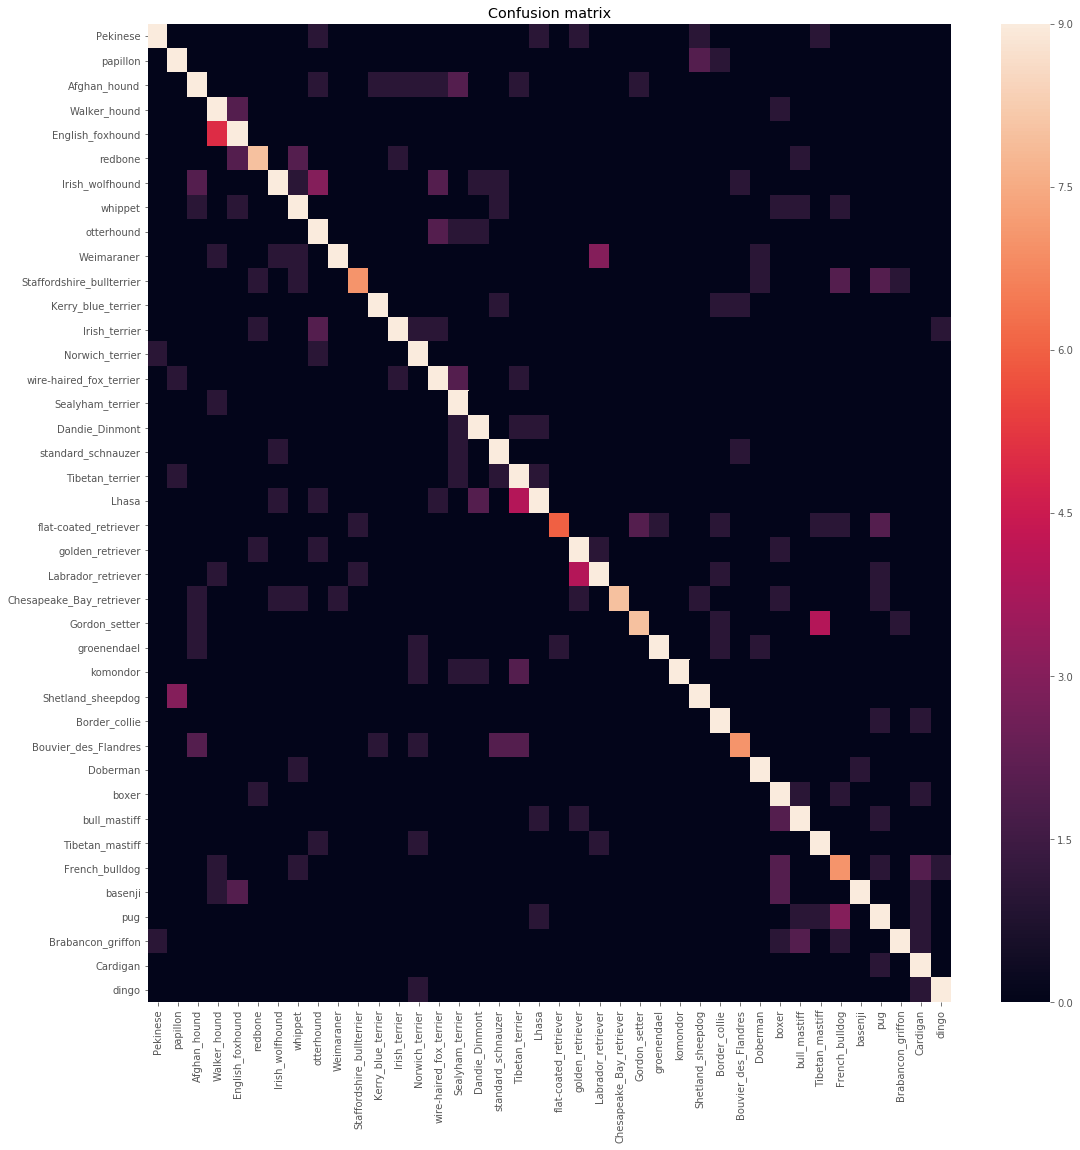